### Import required libraries

In [1]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install top2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 49.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp39-cp39-linux_x86_64.whl size=3582088 sha256=9771b3c3f27161fe4bc768fa027522b700f87cb30862e3aaaec47f987af30dac
  Stored in directory: /root/.cache/pip/wheels/05/6f/88/1a4c04276b98306f00217a1e300e6ba0252c6aa4f7616067ae
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256

In [3]:
!pip install top2vec[sentence_encoders]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 75.6 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import os, time
import io
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from datetime import datetime
import logging
import base64

# Text preprocessing
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import nltk, re
from nltk.corpus import stopwords
from wordcloud import WordCloud
import gensim
from top2vec import Top2Vec

%matplotlib inline

#Spacy libraries
import spacy


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [6]:
np.random.seed(42)

### Top2vec process

[Step 1] Perform embedding to create document and word vectors. Potential models used in this process are Doc2Vec, Universal Sentence Encoder, and BERT Sentence Transformer. Doc2Vec can be trained in two different ways but Top2Vec uses the Distributed Bag of Words (DBOW) instead of the Paragraph Vector with Distributed Memory (DM) algorithm due to better performance and simplicity.

[Step 2] Dimensionality reduction of the embeddings from the previous step using UMAP (Uniform Manifold Approximation and Projection). This step makes the sparse areas in the data to become more dense, thereby helping the topic model quality improve.

[Step 3] Clustering with HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise). HDBSCAN is better at finding clusters of varying densities compared to DBSCAN because it does clustering over a range of epsilon values and tries to find the result that returns the best stability over epsilon.

[Step 4] Calculate the centroid of document vectors with the non-reduced dimensions in each cluster. This centroid is called the topic vector.

[Step 5] Find n-closest word vectors to the topic vector. These are called the topic words.

### Save the article review 

In [7]:
dfImdb = pd.read_csv('/review/IMDB Dataset.csv')

In [8]:
dfImdb.shape

(50000, 2)

In [9]:
dfImdb.columns

Index(['review', 'sentiment'], dtype='object')

### Analyze the overall signals

In [10]:
top2vecModel = Top2Vec(dfImdb['review'].values,embedding_model='universal-sentence-encoder')
top2vecModel.get_num_topics()

2023-03-21 03:47:47,095 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2023-03-21 03:48:31,175 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2023-03-21 03:48:51,313 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-03-21 03:50:10,463 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-03-21 03:51:32,616 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-03-21 03:51:41,468 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


196

In [11]:
top2vecModel.topic_words

array([['troma', 'karloff', 'razzie', ..., 'truffaut', 'wayans', 'coen'],
       ['directorial', 'godard', 'fellini', ..., 'cinematographer',
        'mamet', 'malkovich'],
       ['liotta', 'hackman', 'directorial', ..., 'screenplays', 'akshay',
        'dreyfuss'],
       ...,
       ['paulie', 'tomei', 'fellini', ..., 'jaws', 'lampoon', 'othello'],
       ['scooby', 'shaggy', 'daphne', ..., 'luther', 'blaxploitation',
        'supernatural'],
       ['mickey', 'goofy', 'minnie', ..., 'scrooge', 'jaws', 'comical']],
      dtype='<U15')

In [12]:
top2vecModel.topic_words[0]

array(['troma', 'karloff', 'razzie', 'comedies', 'directorial',
       'watchable', 'mockumentary', 'cronenberg', 'moviegoers',
       'slapstick', 'hellraiser', 'unwatchable', 'campy', 'horror',
       'branagh', 'movie', 'schlock', 'oldboy', 'verhoeven', 'overacting',
       'godard', 'lampoon', 'fellini', 'biopic', 'films', 'liotta',
       'lighthearted', 'tomei', 'comedy', 'coppola', 'lugosi',
       'soderbergh', 'mulholland', 'screenwriters', 'cheesiness', 'film',
       'uwe', 'formulaic', 'dafoe', 'miike', 'miniseries', 'phantasm',
       'viewings', 'screenplay', 'pfeiffer', 'gilliam', 'manos',
       'truffaut', 'wayans', 'coen'], dtype='<U15')

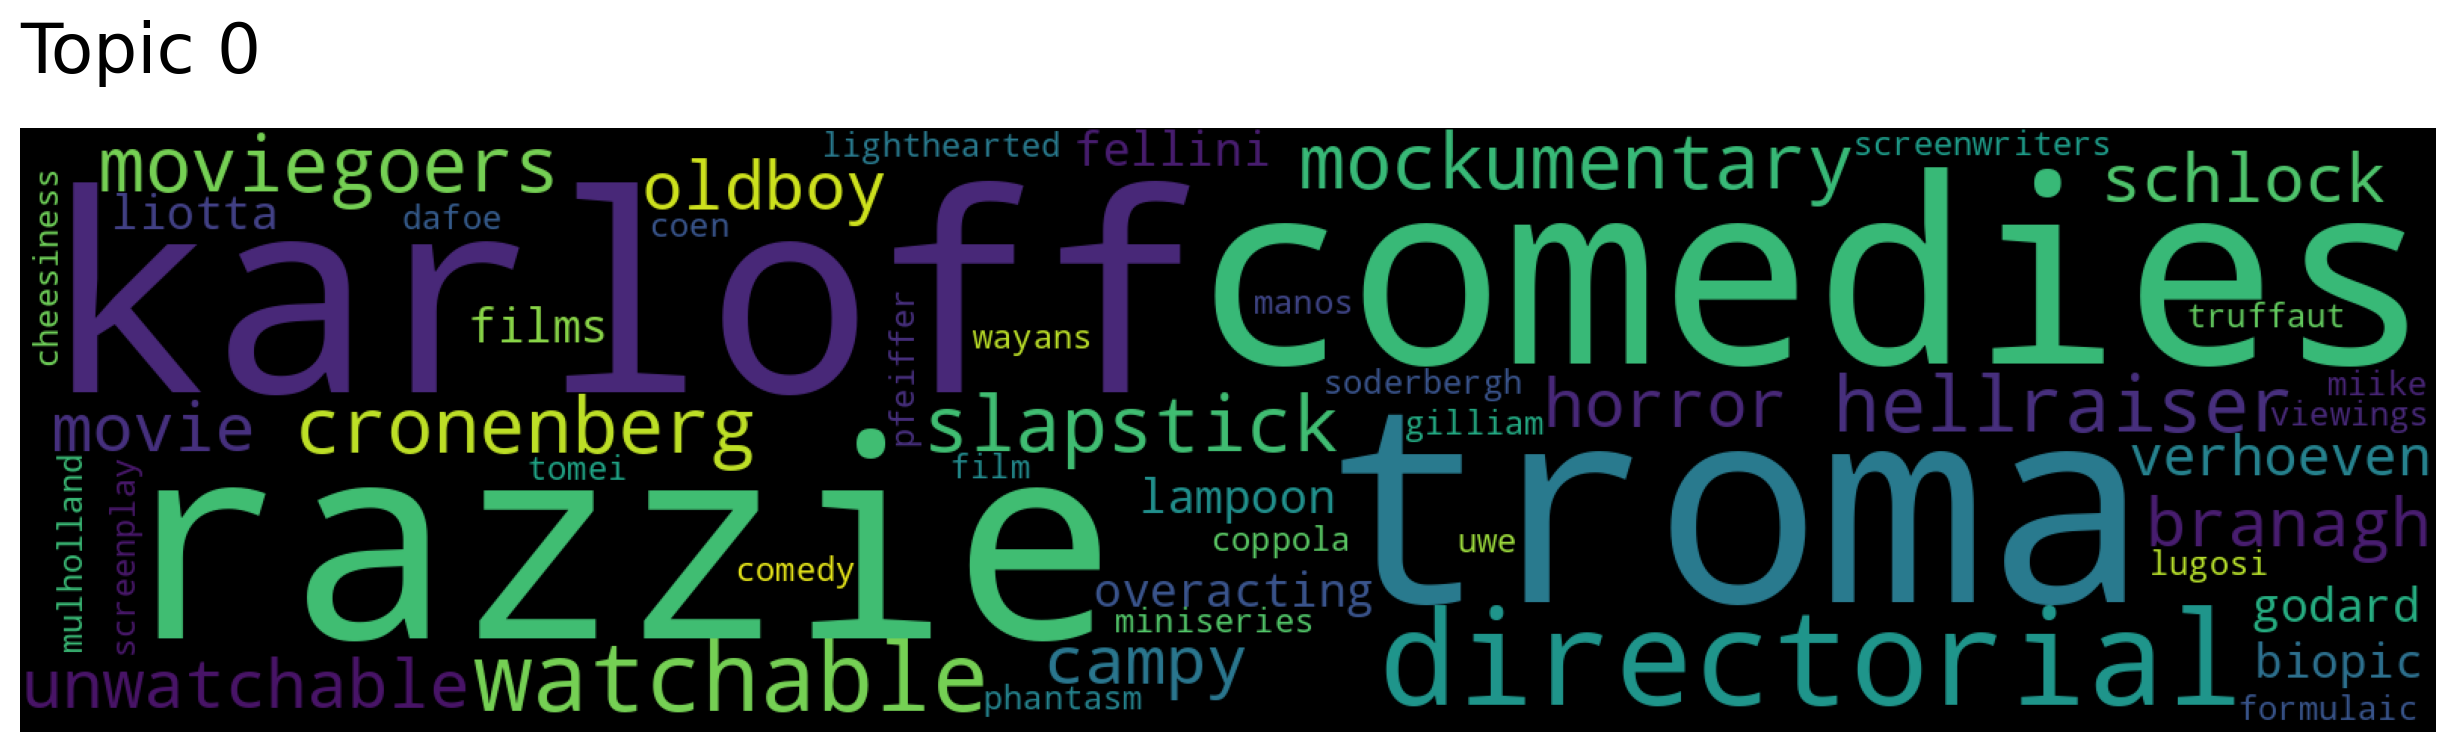

In [13]:
top2vecModel.generate_topic_wordcloud(0)

In [17]:
topic_words, word_scores,topic_scores, topic_nums = top2vecModel.search_topics(keywords=['disney'],num_topics=5)
topic_words, topic_scores

([array(['mickey', 'goofy', 'minnie', 'disney', 'cartoons', 'cartoon',
         'daffy', 'pixar', 'timon', 'animators', 'gromit', 'caricature',
         'steamboat', 'caricatures', 'goof', 'animated', 'looney', 'burt',
         'animator', 'woody', 'elmer', 'muppets', 'monkees', 'tarzan',
         'walt', 'sylvester', 'pumbaa', 'hasselhoff', 'muppet', 'cameos',
         'caddyshack', 'willie', 'hamill', 'campy', 'cartoonish', 'sonny',
         'cinderella', 'donald', 'mouse', 'suzy', 'alvin', 'jerry', 'mabel',
         'asterix', 'cagney', 'stagecoach', 'premiered', 'scrooge', 'jaws',
         'comical'], dtype='<U15'),
  array(['pixar', 'ponyo', 'disney', 'timon', 'cinderella', 'branagh',
         'razzie', 'fellini', 'shrek', 'enchanted', 'tarzan', 'cartoons',
         'gromit', 'animators', 'musicals', 'hercules', 'animated', 'campy',
         'frozen', 'laputa', 'cameos', 'coppola', 'minnie', 'sequels',
         'pumbaa', 'animator', 'cartoon', 'mickey', 'daffy', 'directorial',
   

In [18]:
top2vecModel.search_documents_by_topic(0,num_docs=1)

(array(['OK i gave this a three A three! It deserves only one star no questions asked.<br /><br />If your going to look at the movie seriously and take it as a legit B-Horror movie than yes it will get one star. But i believe it is apparent within the first minutes of the movie what we are dealing with is a piece of crap.<br /><br />With this movie me and the buddy i was watching it with could of turned it off and put on something more "Hollywood" but instead we just decided to rip this whole movie apart from start to finish. We laughed so many times it was almost if i was watching a comedy.<br /><br />The acting is terrible..... The effects and death sequences are so bad.... The Story complete crap.....<br /><br />But the fact they are trying to make a serious horror movie..Priceless!<br /><br />The most memorable part for me is when two of the characters are walking in a supposed "dark basement" which is clearly lit, and they pretend to not be able to see bumping into bones hanging f

### Reducing the topics

In [19]:
top10topics = top2vecModel.hierarchical_topic_reduction(num_topics=10)
top10topics

[[53,
  130,
  23,
  29,
  34,
  89,
  9,
  25,
  137,
  126,
  118,
  150,
  72,
  175,
  181,
  125,
  195,
  69,
  136,
  80,
  154,
  36,
  70,
  99,
  30,
  21,
  86,
  77,
  38,
  78,
  157,
  0],
 [146, 180, 27, 91, 152, 113, 47, 51, 92, 108, 41, 17, 94, 121, 127, 188, 1],
 [145,
  161,
  28,
  185,
  133,
  151,
  7,
  44,
  87,
  90,
  168,
  187,
  40,
  83,
  110,
  123,
  160,
  183,
  20,
  64,
  101,
  139,
  62,
  68,
  74,
  82,
  114,
  155,
  177,
  71,
  10,
  76,
  55,
  132,
  128,
  134,
  75,
  158,
  171,
  174,
  189,
  8,
  14,
  106,
  24,
  103,
  129,
  37,
  162,
  35,
  39,
  102,
  116,
  88,
  79,
  96,
  107,
  104,
  119,
  156,
  164,
  186,
  190,
  2],
 [12, 31, 63, 95, 124, 142, 178, 191, 193, 4],
 [159,
  165,
  117,
  163,
  194,
  84,
  58,
  97,
  166,
  22,
  61,
  143,
  67,
  85,
  111,
  138,
  170,
  16,
  54,
  100,
  169,
  48,
  140,
  33,
  42,
  43,
  112,
  115,
  120,
  167,
  11],
 [60, 50, 56, 18, 179, 135, 32, 105, 147, 184, 6],

In [20]:
top2vecModel.topic_words_reduced[0]

array(['razzie', 'karloff', 'directorial', 'troma', 'watchable',
       'cronenberg', 'comedies', 'mockumentary', 'moviegoers', 'branagh',
       'verhoeven', 'oldboy', 'hellraiser', 'campy', 'slapstick',
       'overacting', 'schlock', 'unwatchable', 'movie', 'godard',
       'fellini', 'liotta', 'horror', 'films', 'coppola', 'biopic',
       'soderbergh', 'pfeiffer', 'mulholland', 'tomei', 'cheesiness',
       'lugosi', 'dafoe', 'formulaic', 'screenwriters', 'lampoon', 'uwe',
       'film', 'miike', 'lighthearted', 'truffaut', 'imdb', 'helsing',
       'manos', 'miniseries', 'unrated', 'phantasm', 'filmmaking',
       'cagney', 'movies'], dtype='<U14')

In [21]:
top2vecModel.topic_words_reduced[2]

array(['oldboy', 'verhoeven', 'godard', 'hackman', 'liotta', 'biopic',
       'directorial', 'branagh', 'cagney', 'fellini', 'coppola',
       'costner', 'razzie', 'bergman', 'overacting', 'truffaut', 'creasy',
       'bacall', 'keitel', 'coen', 'moviegoers', 'portrayal',
       'braveheart', 'screenwriters', 'pfeiffer', 'kurosawa', 'hartnett',
       'films', 'slapstick', 'trainspotting', 'mockumentary', 'subplot',
       'portrayed', 'tomei', 'akshay', 'bronson', 'pacino', 'scorsese',
       'herzog', 'soderbergh', 'karloff', 'dreyfuss', 'voight', 'bardem',
       'fishburne', 'blaxploitation', 'henchman', 'schlock', 'poitier',
       'damme'], dtype='<U14')

In [22]:
word, word_score = top2vecModel.similar_words(keywords=['disney'], num_words=15)
for word,score in zip(word, word_score):
    print(f"{word} {score}")

nickelodeon 0.5449021092447712
pixar 0.5371870959270342
cartoons 0.5285808764992092
mickey 0.5279717061142652
wwe 0.5005567596951503
hollywood 0.4966752335758783
cartoon 0.4932292640422853
celebrity 0.48673796814684894
minnie 0.47888263477375537
rides 0.4703733980417661
mgm 0.4679185997348559
marvel 0.46221464427206493
parks 0.46007261903778573
goofy 0.45730105860010517
cinderella 0.4564084758787249


In [24]:
word, word_score = top2vecModel.similar_words(keywords=['cartoon'], num_words=15)
for word,score in zip(word, word_score):
    print(f"{word} {score}")

cartoons 0.8063535717455329
caricature 0.7327080725521666
caricatures 0.6936631239791059
animated 0.6484321086030935
cartoonish 0.6318490000746072
anime 0.5914811296803852
comics 0.581720585521469
animation 0.5699719998396021
animators 0.568030731018708
comic 0.5617598090859253
depiction 0.5484142764931879
stylized 0.5333533343568495
nickelodeon 0.5203825870095791
depicting 0.5190887901780887
animator 0.5153096650337919


### Negative sentiment articles

In [25]:
startTime = time.time()
top2vecModel_neg = Top2Vec(dfImdb[dfImdb.sentiment=='negative']['review'].values,embedding_model='universal-sentence-encoder')
top2vecModel_neg.get_num_topics()
endTime = time.time()
print("elapsed time: {} seconds".format(round(endTime-startTime,1)))

2023-03-21 03:58:34,791 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2023-03-21 03:58:54,347 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2023-03-21 03:59:04,396 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-03-21 03:59:50,275 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-03-21 04:00:26,926 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-03-21 04:00:32,850 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


elapsed time: 120.0 seconds


In [26]:
top2vecModel_neg.topic_words

array([['comedies', 'watchable', 'directorial', ..., 'bergman',
        'kaufman', 'dreadful'],
       ['karloff', 'hellraiser', 'horror', ..., 'remakes', 'manos',
        'overacting'],
       ['screenwriters', 'directorial', 'branagh', ..., 'miscast',
        'portraying', 'acting'],
       ...,
       ['carly', 'sitcoms', 'sitcom', ..., 'slapstick', 'trashy',
        'miranda'],
       ['batman', 'affleck', 'keaton', ..., 'animated', 'screenwriters',
        'cagney'],
       ['superman', 'reeves', 'superhero', ..., 'disjointed', 'subplots',
        'carell']], dtype='<U15')

In [27]:
top2vecModel_neg.topic_words[0]

array(['comedies', 'watchable', 'directorial', 'unwatchable', 'troma',
       'movie', 'lampoon', 'schlock', 'overacting', 'slapstick',
       'branagh', 'wayans', 'screenwriters', 'comedic', 'uwe', 'comedy',
       'films', 'carell', 'karloff', 'screenplay', 'formulaic', 'campy',
       'film', 'hackman', 'unfunny', 'sandler', 'filmmaking', 'cagney',
       'stiller', 'movies', 'manos', 'imdb', 'dreck', 'cinematography',
       'flick', 'costner', 'parody', 'carrey', 'miniseries', 'subplot',
       'dafoe', 'miscast', 'damme', 'critics', 'arquette', 'belushi',
       'screenwriter', 'bergman', 'kaufman', 'dreadful'], dtype='<U15')

In [28]:
topic_words_neg, word_scores,topic_scores_neg, topic_nums = top2vecModel_neg.search_topics(keywords=['failure'],num_topics=5)
topic_words_neg, topic_scores_neg

([array(['seagal', 'damme', 'segal', 'stallone', 'akshay', 'carradine',
         'directorial', 'bronson', 'hackman', 'tarantino', 'lundgren',
         'uwe', 'rambo', 'rourke', 'watchable', 'slapstick', 'thurman',
         'choreographed', 'robocop', 'schwarzenegger', 'films', 'arquette',
         'bollywood', 'cagney', 'costner', 'troma', 'stunts', 'wayans',
         'boll', 'swayze', 'travolta', 'overacting', 'pacino',
         'screenwriters', 'dafoe', 'actor', 'schlock', 'eastwood',
         'filmmaker', 'bachchan', 'comedies', 'blade', 'flicks', 'bergman',
         'scorsese', 'rampage', 'norris', 'carell', 'flick', 'action'],
        dtype='<U15'),
  array(['elvis', 'cagney', 'kaufman', 'belushi', 'hepburn', 'walken',
         'arquette', 'travolta', 'hackman', 'carrey', 'bogart', 'heston',
         'costner', 'pacino', 'cameos', 'stallone', 'sandler', 'swayze',
         'lampoon', 'branagh', 'bergman', 'portrayals', 'portrayal',
         'formulaic', 'niro', 'notorious', 'schlo

In [29]:
top2vecModel_neg.search_documents_by_topic(0,num_docs=1)

(array(["I saw this in a preview screening and have to say that this documentary style movie is the biggest load of tripe I have ever seen.<br /><br />Completely unfunny, low budget, boring, rubbish script, terrible acting - The entire audience (young and old) sat through the film comatose without laughing for most of it... there were literally only about 2 places you will laugh in the entire movie<br /><br />Many people left halfway - Can't blame them... I stayed thinking that the film would pick up, however, it never did and I wish I'd left. <br /><br />The humour was really lame and I am surprised that this ever made it on to the big screen. I am not someone who is offended by the adult content of this movie at all - It just wasn't funny. The people who made this movie really don't deserve your money, so please don't pay to see this film.<br /><br />This isn't even funny enough to be shown on TV, let alone cinema...<br /><br />I wanted to give it 0 out of 10, but the system won't al

In [30]:
top10topics_neg = top2vecModel_neg.hierarchical_topic_reduction(num_topics=10)
top2vecModel_neg.topic_words_reduced[1]

array(['directorial', 'screenwriters', 'branagh', 'watchable', 'schlock',
       'overacting', 'screenplay', 'filmmaking', 'films', 'portrayed',
       'cinematography', 'subplot', 'formulaic', 'unwatchable',
       'filmmaker', 'movie', 'film', 'screenwriter', 'bergman',
       'filmmakers', 'karloff', 'portrayal', 'troma', 'hackman',
       'subplots', 'comedies', 'slapstick', 'miniseries', 'spielberg',
       'movies', 'costner', 'kaufman', 'kubrick', 'theatrical',
       'portrayals', 'welles', 'hitchcock', 'lampoon', 'uwe', 'scorsese',
       'miscast', 'melodrama', 'imdb', 'campy', 'cagney', 'scenes',
       'tarantino', 'monologues', 'lugosi', 'dreadful'], dtype='<U15')

In [33]:
topic_words_neg, word_scores_neg, topic_nums_neg = top2vecModel_neg.get_topics(num_topics=10,reduced=True)
print(f"No of negative document topics {topic_nums_neg}")

for i,topic in enumerate(top10topics_neg):
    print(f"Topic {i}: {topic}")
    print(f"Keywords : {topic_words_neg[i]}")
    print('\n')

No of negative document topics [0 1 2 3 4 5 6 7 8 9]
Topic 0: [43, 49, 53, 11, 0]
Keywords : ['watchable' 'comedies' 'directorial' 'troma' 'unwatchable' 'movie'
 'schlock' 'overacting' 'branagh' 'lampoon' 'slapstick' 'karloff'
 'screenwriters' 'uwe' 'films' 'campy' 'wayans' 'formulaic' 'screenplay'
 'film' 'hackman' 'carell' 'cagney' 'imdb' 'comedic' 'filmmaking' 'movies'
 'comedy' 'manos' 'sandler' 'costner' 'subplot' 'miscast' 'dafoe' 'dreck'
 'cinematography' 'miniseries' 'flick' 'stiller' 'unfunny' 'arquette'
 'bergman' 'critics' 'damme' 'dreadful' 'screenwriter' 'spielberg'
 'portrayal' 'boll' 'carrey']


Topic 1: [10, 47, 64, 66, 73, 22, 41, 28, 56, 2]
Keywords : ['directorial' 'screenwriters' 'branagh' 'watchable' 'schlock'
 'overacting' 'screenplay' 'filmmaking' 'films' 'portrayed'
 'cinematography' 'subplot' 'formulaic' 'unwatchable' 'filmmaker' 'movie'
 'film' 'screenwriter' 'bergman' 'filmmakers' 'karloff' 'portrayal'
 'troma' 'hackman' 'subplots' 'comedies' 'slapstick' 'min

In [35]:
word, word_score = top2vecModel_neg.similar_words(keywords=['boring'], num_words=15)
for word,score in zip(word, word_score):
    print(f"{word} {score}")

uninteresting 0.7190519304873273
dull 0.7149993375238012
bored 0.6890011085424163
tiresome 0.6714533288035965
blah 0.6631422341089239
monotonous 0.6451262476658846
tedious 0.6409006866904724
horrible 0.6160101147149013
boredom 0.6159015869418779
lackluster 0.6155047360341432
terrible 0.6135058663373212
dreadful 0.6090168180508357
miserable 0.6036136075419145
crappy 0.5968143610894464
bland 0.5946489191269815


In [36]:
word, word_score = top2vecModel_neg.similar_words(keywords=['flop'], num_words=15)
for word,score in zip(word, word_score):
    print(f"{word} {score}")

lackluster 0.5425289482968103
contrived 0.5312333994107905
unsatisfying 0.5238185025477609
foul 0.5233595189006153
clumsy 0.5187484881071628
unappealing 0.5169728319595023
comical 0.5130905218650738
dropped 0.5125993507357351
jerk 0.5123092500411696
slapped 0.5039070759734647
dive 0.5017751845260845
slap 0.49777556765121744
uninspiring 0.4957877726958769
doomed 0.495745574038156
embarrassing 0.4914281170466288


### Positive sentiment sentences

In [37]:
startTime = time.time()
top2vecModel_pos = Top2Vec(dfImdb[dfImdb.sentiment=='positive']['review'].values,embedding_model='universal-sentence-encoder')
top2vecModel_pos.get_num_topics()
endTime = time.time()
print("elapsed time: {} seconds".format(round(endTime-startTime,1)))

2023-03-21 04:03:19,216 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2023-03-21 04:03:43,146 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2023-03-21 04:03:51,550 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-03-21 04:04:45,089 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-03-21 04:05:12,361 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-03-21 04:05:14,086 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


elapsed time: 115.5 seconds


In [38]:
top2vecModel_pos.topic_words

array([['directorial', 'cinematography', 'filmmaking', ..., 'theatrical',
        'karloff', 'fiennes'],
       ['bergman', 'pfeiffer', 'coppola', ..., 'soderbergh', 'fiennes',
        'dramas'],
       ['comedies', 'slapstick', 'lighthearted', ..., 'karloff',
        'movies', 'filmography'],
       ...,
       ['jerry', 'sylvester', 'tom', ..., 'showdown', 'stuart', 'mick'],
       ['karloff', 'metal', 'campy', ..., 'movie', 'killer', 'argento'],
       ['scarlett', 'branagh', 'rhett', ..., 'spielberg', 'poitier',
        'hitchcock']], dtype='<U15')

In [39]:
top2vecModel_pos.topic_words[0]

array(['directorial', 'cinematography', 'filmmaking', 'biopic',
       'filmmaker', 'mulholland', 'branagh', 'films', 'watchable',
       'viewings', 'filmmakers', 'verhoeven', 'film', 'screenplay',
       'soderbergh', 'bergman', 'coppola', 'coen', 'movie', 'kurosawa',
       'portrayed', 'troma', 'cinematographer', 'cronenberg', 'spielberg',
       'ebert', 'scorsese', 'formulaic', 'portrayal', 'screenwriter',
       'kubrick', 'herzog', 'memento', 'movies', 'welles', 'miniseries',
       'tarantino', 'subplot', 'comedies', 'hitchcock', 'gilliam',
       'portrayals', 'visuals', 'bacall', 'documentary', 'slapstick',
       'malkovich', 'theatrical', 'karloff', 'fiennes'], dtype='<U15')

In [40]:
topic_words_pos, word_scores,topic_scores_pos, topic_nums = top2vecModel_pos.search_topics(keywords=['growth'],num_topics=5)
topic_words_pos, topic_scores_pos

([array(['thriller', 'miike', 'karloff', 'billie', 'micheal',
         'choreography', 'michael', 'choreographed', 'scarface',
         'cronenberg', 'lugosi', 'janet', 'thrillers', 'dancer',
         'frankenstein', 'chucky', 'viewings', 'slapstick', 'pfeiffer',
         'cameos', 'jaws', 'dances', 'directorial', 'astaire', 'madonna',
         'welles', 'filmmaking', 'bela', 'exorcist', 'gromit', 'vhs',
         'movie', 'hokey', 'dance', 'coppola', 'mulholland', 'polanski',
         'troma', 'filmed', 'montage', 'film', 'boogie', 'michel', 'movies',
         'soderbergh', 'filmmaker', 'tribute', 'godfather', 'pulp',
         'masterpieces'], dtype='<U15'),
  array(['pixar', 'ponyo', 'animated', 'gromit', 'watchable', 'cartoons',
         'branagh', 'films', 'timon', 'lighthearted', 'troma', 'spielberg',
         'campy', 'disney', 'movie', 'directorial', 'cartoon', 'comedies',
         'laputa', 'slapstick', 'karloff', 'enchanted', 'miniseries',
         'verhoeven', 'movies', 'anima

In [41]:
top2vecModel_pos.search_documents_by_topic(0,num_docs=1)

(array(["This film, as low budget as it may be, is one of the best psychological thrillers I've ever seen. If you accept that it's low budget from the start, you can appreciate just how good of a story it is, how very well written the script is, and how great the filmmaker was to produce something so wonderful with so little money.<br /><br />All the elements of a great film are here. The visuals, though shot on digital, were gorgeous in places. The bizarre, dreamy feel of the film is captured particularly well in the scene with the talking dog, that scene was just amazing. It's such a trippy piece of work, but not done in a pretentious way, and because of that I have a whole lot of respect for this film. It comes highly recommended to anyone looking for something unique and captivating, and different from much of the repetitive films that are out there."],
       dtype=object), array([0.8422241], dtype=float32), array([9607]))

In [43]:
top10topics_pos = top2vecModel_pos.hierarchical_topic_reduction(num_topics=10)
top2vecModel_pos.topic_words_reduced[1]

array(['bergman', 'cagney', 'branagh', 'bacall', 'directorial', 'coppola',
       'pfeiffer', 'biopic', 'miscast', 'verhoeven', 'portrayal', 'coen',
       'cameos', 'duchovny', 'miniseries', 'comedies', 'pegg', 'sarandon',
       'watchable', 'pacino', 'imdb', 'karloff', 'scorsese', 'films',
       'carell', 'fiennes', 'soderbergh', 'kilmer', 'formulaic',
       'hitchcock', 'welles', 'slapstick', 'actresses', 'sopranos',
       'musicals', 'viewings', 'barrymore', 'troma', 'cinematography',
       'poitier', 'emmy', 'filmography', 'portrayals', 'voight', 'streep',
       'brando', 'akshay', 'mulholland', 'deniro', 'theatrical'],
      dtype='<U15')

In [44]:
topic_words_pos, word_scores_pos, topic_nums_pos = top2vecModel_pos.get_topics(num_topics=10,reduced=True)
print(f"No of positive document topics {topic_words_pos}")

for i,topic in enumerate(top10topics_pos):
    print(f"Topic {i}: {topic}")
    print(f"Keywords : {topic_words_pos[i]}")
    print('\n')

No of positive document topics [['directorial' 'biopic' 'branagh' 'cinematography' 'mulholland'
  'filmmaking' 'verhoeven' 'films' 'watchable' 'bergman' 'filmmaker'
  'viewings' 'film' 'cronenberg' 'screenplay' 'movie' 'coppola' 'coen'
  'filmmakers' 'soderbergh' 'troma' 'miniseries' 'formulaic' 'kurosawa'
  'herzog' 'portrayed' 'spielberg' 'portrayal' 'movies' 'comedies'
  'ebert' 'scorsese' 'screenwriter' 'subplot' 'welles' 'memento'
  'gilliam' 'karloff' 'kubrick' 'bacall' 'slapstick' 'cinematographer'
  'hitchcock' 'pfeiffer' 'fiennes' 'tarantino' 'theatrical' 'miike'
  'lighthearted' 'portrayals']
 ['bergman' 'cagney' 'branagh' 'bacall' 'directorial' 'coppola'
  'pfeiffer' 'biopic' 'miscast' 'verhoeven' 'portrayal' 'coen' 'cameos'
  'duchovny' 'miniseries' 'comedies' 'pegg' 'sarandon' 'watchable'
  'pacino' 'imdb' 'karloff' 'scorsese' 'films' 'carell' 'fiennes'
  'soderbergh' 'kilmer' 'formulaic' 'hitchcock' 'welles' 'slapstick'
  'actresses' 'sopranos' 'musicals' 'viewings' 'barr

In [48]:
word, word_score = top2vecModel_pos.similar_words(keywords=['horror'], num_words=15)
for word,score in zip(word, word_score):
    print(f"{word} {score}")

horrors 0.6688110550646607
thrillers 0.6428816847823451
comedy 0.6104271011361632
suspense 0.5932746577566292
haunting 0.5546148658013663
scary 0.5467328524533249
gory 0.5397295959182935
grim 0.5325768927972135
frightening 0.5324884764363338
horrifying 0.5283889118067197
scares 0.5243213249590382
sinister 0.523313127799467
haunted 0.5191626612059377
drama 0.5186347614127321
scare 0.5164398885748636


In [51]:
# query topics based on given text input
topic_words, word_scores, topic_scores, topic_nums =\
top2vecModel_pos.query_topics('bottom 5 directors', num_topics=2)

print("first topic: ", topic_words[0])
print("\n")
print("second topic: ", topic_words[1])

first topic:  ['directorial' 'cinematography' 'filmmaking' 'biopic' 'filmmaker'
 'mulholland' 'branagh' 'films' 'watchable' 'viewings' 'filmmakers'
 'verhoeven' 'film' 'screenplay' 'soderbergh' 'bergman' 'coppola' 'coen'
 'movie' 'kurosawa' 'portrayed' 'troma' 'cinematographer' 'cronenberg'
 'spielberg' 'ebert' 'scorsese' 'formulaic' 'portrayal' 'screenwriter'
 'kubrick' 'herzog' 'memento' 'movies' 'welles' 'miniseries' 'tarantino'
 'subplot' 'comedies' 'hitchcock' 'gilliam' 'portrayals' 'visuals'
 'bacall' 'documentary' 'slapstick' 'malkovich' 'theatrical' 'karloff'
 'fiennes']


second topic:  ['biopic' 'directorial' 'pacino' 'scorsese' 'deniro' 'cagney' 'branagh'
 'coppola' 'bergman' 'kilmer' 'bacall' 'fiennes' 'bronson' 'verhoeven'
 'pfeiffer' 'niro' 'voight' 'denzel' 'coen' 'cinematography' 'caine'
 'spielberg' 'fishburne' 'poitier' 'brando' 'actor' 'portrayal' 'travolta'
 'films' 'cameos' 'filmography' 'welles' 'scarface' 'actors' 'duchovny'
 'hoffman' 'cusack' 'akshay' 'errol' '

In [52]:
# query topics based on given text input
topic_words, word_scores, topic_scores, topic_nums =\
top2vecModel_pos.query_topics('top 5 directors', num_topics=2)

print("first topic: ", topic_words[0])
print("\n")
print("second topic: ", topic_words[1])

first topic:  ['biopic' 'directorial' 'pacino' 'scorsese' 'deniro' 'cagney' 'branagh'
 'coppola' 'bergman' 'kilmer' 'bacall' 'fiennes' 'bronson' 'verhoeven'
 'pfeiffer' 'niro' 'voight' 'denzel' 'coen' 'cinematography' 'caine'
 'spielberg' 'fishburne' 'poitier' 'brando' 'actor' 'portrayal' 'travolta'
 'films' 'cameos' 'filmography' 'welles' 'scarface' 'actors' 'duchovny'
 'hoffman' 'cusack' 'akshay' 'errol' 'miniseries' 'troma' 'nicholson'
 'pegg' 'hitchcock' 'cronenberg' 'screenplay' 'screenwriter' 'filmmaking'
 'acting' 'tarantino']


second topic:  ['directorial' 'coppola' 'pfeiffer' 'cagney' 'bronson' 'verhoeven'
 'biopic' 'kilmer' 'pacino' 'scorsese' 'troma' 'bergman' 'bacall'
 'thrillers' 'tarantino' 'scarface' 'films' 'deniro' 'branagh' 'fishburne'
 'miscast' 'comedies' 'cronenberg' 'formulaic' 'stallone' 'pegg' 'akshay'
 'screenplay' 'cinematography' 'fiennes' 'subplots' 'campy' 'karloff'
 'movie' 'watchable' 'riddick' 'caine' 'miniseries' 'subplot' 'mulholland'
 'duchovny' 'den